# MonReader_ViT
- Author: Yumo Bai
- Email: baiym104@gmail.com
- Date: May 3

Now that we have a functional CNN model working, we can move on to leverage the pretrained Vision Transformer (ViT) model to obtain a better solution. We will be accessing the ViT model through the HuggingFace API.

## Package Installation & Setup

In [4]:
!pip install transformers "datasets>=1.17.0" tensorboard --upgrade
!sudo apt-get install git-lfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [5]:
# Log into our HuggingFace account to access the models
from huggingface_hub import notebook_login

notebook_login()


In this example are we going to fine-tune the google/vit-base-patch16-224-in21k a Vision Transformer (ViT) pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224.

In [6]:
model_id = "google/vit-base-patch16-224-in21k"

### Preparing & Preprocessing the Dataset

Since we are using a custom dataset, we would need to convert them into a `Dataset` instance so the model could be fine tuned on it.

In [7]:
# Unzip the dataset
import os
import zipfile
import numpy as np

local_zip = './images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('.')
zip_ref.close()

In [8]:
import datasets

def create_image_folder_dataset(root_path):
  """creates `Dataset` from image folder structure"""

  # get class names by folders names
  _CLASS_NAMES= ['flip', 'notflip']
  # defines `datasets` features`
  features=datasets.Features({
                      "img": datasets.Image(),
                      "label": datasets.features.ClassLabel(names=_CLASS_NAMES),
                  })
  # temp list holding datapoints for creation
  img_data_files=[]
  label_data_files=[]
  # load images into list for creation
  for img_class in _CLASS_NAMES:
    for img in os.listdir(os.path.join(root_path,img_class)):
      path_=os.path.join(root_path,img_class,img)
      img_data_files.append(path_)
      label_data_files.append(img_class)
  # create dataset
  ds = datasets.Dataset.from_dict({"img":img_data_files,"label":label_data_files},features=features)
  return ds

In [19]:
ROOT_DIR = './images'
TRAIN_DIR = os.path.join(ROOT_DIR, 'training')
TEST_DIR = os.path.join(ROOT_DIR, 'testing')

train_ds = create_image_folder_dataset(TRAIN_DIR)
test_ds = create_image_folder_dataset(TEST_DIR)

#### Image Augmentation

In [20]:
from transformers import ViTFeatureExtractor
import tensorflow as tf

# Set up GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)

# learn more about data augmentation here: https://www.tensorflow.org/tutorials/images/data_augmentation
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Resizing(720, 720),
        tf.keras.layers.Rescaling(1./255),
    ],
    name="data_augmentation",
)
# use keras image data augementation processing
def process(examples):
    examples.update(feature_extractor(examples['img'], ))
    return examples

Found GPU at: /device:GPU:0


In [21]:
# we are also renaming our label col to labels to use `.to_tf_dataset` later
train_ds = train_ds.rename_column("label", "labels")
test_ds = test_ds.rename_column("label", "labels")

train_ds = train_ds.map(process, batched=True, batch_size=8)
test_ds = test_ds.map(process, batched=True, batch_size=8)

Map:   0%|          | 0/2392 [00:00<?, ? examples/s]

Map:   0%|          | 0/597 [00:00<?, ? examples/s]

In [26]:
from huggingface_hub import HfFolder
import tensorflow as tf

img_class_labels = ['flip', 'notflip']

id2label = {str(i): label for i, label in enumerate(img_class_labels)}
label2id = {v: k for k, v in id2label.items()}

num_train_epochs = 15
train_batch_size = 32
eval_batch_size = 32
learning_rate = 3e-5
weight_decay_rate=0.01
num_warmup_steps=0
output_dir=model_id.split("/")[1]
hub_token = HfFolder.get_token() # or your token directly "hf_xxx"
hub_model_id = f'{model_id.split("/")[1]}-MR'
fp16=True

# Train in mixed-precision float16
if fp16:
  tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [23]:
from transformers import DefaultDataCollator

# Data collator that will dynamically pad the inputs received, as well as the labels.
data_collator = DefaultDataCollator(return_tensors="tf")

# converting our train dataset to tf.data.Dataset
tf_train_dataset = train_ds.to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["labels"],
   shuffle=True,
   batch_size=train_batch_size,
   collate_fn=data_collator)

# converting our test dataset to tf.data.Dataset
tf_eval_dataset = test_ds.to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["labels"],
   shuffle=True,
   batch_size=eval_batch_size,
   collate_fn=data_collator)

In [24]:
from transformers import TFViTForImageClassification, create_optimizer
import tensorflow as tf

# create optimizer wight weigh decay
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=num_warmup_steps,
)

# load pre-trained ViT model
model = TFViTForImageClassification.from_pretrained(
    model_id,
    num_labels=len(img_class_labels),
    id2label=id2label,
    label2id=label2id,
)

# define loss
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# define metrics
metrics=[
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
]

# compile model
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics
              )


In [25]:
import os
from transformers.keras_callbacks import PushToHubCallback
from keras.callbacks import TensorBoard as TensorboardCallback, EarlyStopping

callbacks=[]

callbacks.append(TensorboardCallback(log_dir=os.path.join(output_dir,"logs")))
callbacks.append(EarlyStopping(monitor="val_accuracy",patience=1))
if hub_token:
  callbacks.append(PushToHubCallback(output_dir=output_dir,
                                     hub_model_id=hub_model_id,
                                     hub_token=hub_token))

In [27]:
with tf.device('/device:GPU:0'):

  train_results = model.fit(
      tf_train_dataset,
      validation_data=tf_eval_dataset,
      callbacks=callbacks,
      epochs=num_train_epochs,
  )

Epoch 1/15
75/75 [==============================] - 233s 3s/step - loss: 0.3224 - accuracy: 0.9009 - top-3-accuracy: 1.0000 - val_loss: 0.0773 - val_accuracy: 0.9933 - val_top-3-accuracy: 1.0000
Epoch 2/15
75/75 [==============================] - 195s 3s/step - loss: 0.0455 - accuracy: 0.9962 - top-3-accuracy: 1.0000 - val_loss: 0.0652 - val_accuracy: 0.9849 - val_top-3-accuracy: 1.0000


### Model Evaluation

In [28]:
model.evaluate(tf_eval_dataset)

19/19 [==============================] - 41s 2s/step - loss: 0.0652 - accuracy: 0.9849 - top-3-accuracy: 1.0000


[0.06517782807350159, 0.9849246144294739, 1.0]

Our model achieved 98.5% accuracy on the testing dataset. Let's dive further and examine the roc and F1-score of the model.

In [47]:
logits = model.predict(tf_eval_dataset, verbose=1)['logits']
preds = np.argmax(logits, axis=1)

19/19 [==============================] - 37s 2s/step


In [42]:
from sklearn.metrics import roc_curve, auc

true_labels = np.concatenate([y for x, y in tf_eval_dataset], axis=0)

fpr, tpr, _ = roc_curve(true_labels, preds)
roc_auc = auc(fpr, tpr)

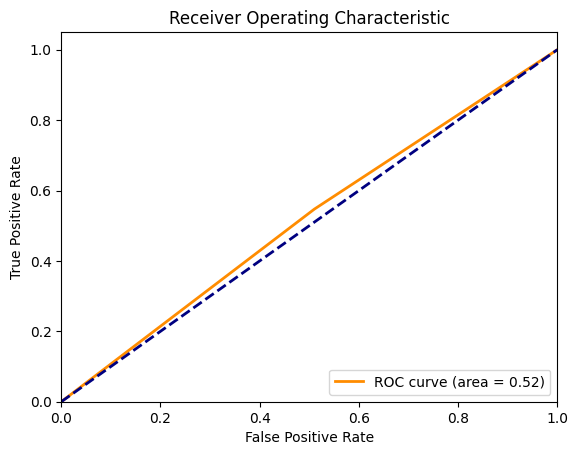

In [44]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()